In [1]:
# 필요한 라이브러리 호출

import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
import random
from PIL import Image
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
torch.cuda.empty_cache()

In [2]:
# 데이터 전처리

from typing import Any


class ImageTransform():
    
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
    
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [3]:
# 데이터를 가져와서 훈련, 검증, 테스트 용도로 분리

cat_directory = './data/dogs-vs-cats/Cat/'
dog_directory = './data/dogs-vs-cats/Dog/'
human_directory = './data/dogs-vs-cats/Test/'

cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])
human_images_filepaths = sorted([os.path.join(human_directory, f) for f in os.listdir(human_directory)])
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]

correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:4000]
val_images_filepaths = correct_images_filepaths[4000: 4920]
test_images_filepaths = [*correct_images_filepaths[-10:], *human_images_filepaths]
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

4000 920 20


In [4]:
# torch.utils.data.Dataset을 상속받아 커스텀 데이터셋을 정의

class DogvsCatDataset(Dataset):

    def __init__(self, file_list, transform=None, phase='train'):
        # 이미지 데이터가 위치한 파일 경로, 채널이 3개인 이미지를 필터링
        self.file_list = file_list
        self.file_list = [f for f in self.file_list if Image.open(f).mode == 'RGB']
        # 이미지 데이터 전처리
        self.transform = transform
        # self.phase는 ImageTransform()에서 정의한 'train'과 'val'을 의미
        self.phase = phase
    
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        # 이미지 데이터의 인덱스를 가져오기
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)

        # 레이블 값을 가져오기
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0

        # 전처리가 적용된 이미지와 레이블 반환
        return img_transformed, label

In [5]:
# 변수에 대한 값 정의

# AlexNet은 깊이가 깊은 네트워크를 사용하므로 이미지 크기가 256이 아니면 풀링충 때문에 크기가 계속 줄어들어 오류가 발생할 수 있음

size = 256
# 파이토치의 사전 학습된 모델을 사용할 때, 모델이 학습된 데이터셋의 통계를 기반으로 함
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
# 배치 사이즈는 gpu의 메모리 용량에 따라서 달리하는 것이 좋다.
batch_size = 64

In [6]:
# 훈련, 검증, 테스트 데이터셋 정의

train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')
test_dataset = DogvsCatDataset(test_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 256, 256])
0


In [7]:
# 데이터셋을 메모리로 불러옴

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {
    'train': train_dataloader,
    'val': val_dataloader,
}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
# 배치 사이즈가 커지니까 label의 크기도 커졌다.
print(label)

torch.Size([64, 3, 256, 256])
tensor([0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1,
        0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1])


In [8]:
# AlexNet 모델 네트워크 정의

class AlexNet(nn.Module):

    def __init__(self) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256*6*6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 2),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [9]:
# model 객체 생성

model = AlexNet()
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [10]:
# 옵티마이저 및 손실 함수 정의

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [11]:
# 모델 네트워크 구조 확인
from torchsummary import summary

summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]          23,296
              ReLU-2           [-1, 64, 63, 63]               0
         MaxPool2d-3           [-1, 64, 31, 31]               0
            Conv2d-4          [-1, 192, 31, 31]         307,392
              ReLU-5          [-1, 192, 31, 31]               0
         MaxPool2d-6          [-1, 192, 15, 15]               0
            Conv2d-7          [-1, 384, 15, 15]         663,936
              ReLU-8          [-1, 384, 15, 15]               0
            Conv2d-9          [-1, 256, 15, 15]         884,992
             ReLU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]         590,080
             ReLU-12          [-1, 256, 15, 15]               0
        MaxPool2d-13            [-1, 256, 7, 7]               0
AdaptiveAvgPool2d-14            [-1, 25

In [12]:
# 모델 학습 함수 정의

def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):
    since = time.time()
    best_acc = 0.0

    for epoch in range(num_epoch):
        print(f'Epoch {epoch+1}/{num_epoch}')
        print('-' * 40)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            epoch_loss = 0.0
            epoch_corrects = 0

            # leave=False를 통해 이전 진행 내용을 삭제
            for inputs, labels in tqdm(dataloader_dict[phase], leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        # 모든 파라미터의 기울기 계산
                        loss.backward()
                        # 파라미터 갱신
                        optimizer.step()
                    
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    
    return model


In [13]:
# 모델 학습
num_epoch = 10
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/10
----------------------------------------


train Loss: 0.6931 Acc: 0.5060


val Loss: 0.6927 Acc: 0.5174
Epoch 2/10
----------------------------------------


train Loss: 0.6930 Acc: 0.5078


val Loss: 0.6927 Acc: 0.5174
Epoch 3/10
----------------------------------------


train Loss: 0.6928 Acc: 0.5153


val Loss: 0.6925 Acc: 0.5174
Epoch 4/10
----------------------------------------


train Loss: 0.6928 Acc: 0.5093


val Loss: 0.6925 Acc: 0.5196
Epoch 5/10
----------------------------------------


train Loss: 0.6928 Acc: 0.5318


val Loss: 0.6924 Acc: 0.5598
Epoch 6/10
----------------------------------------


train Loss: 0.6927 Acc: 0.5173


val Loss: 0.6922 Acc: 0.5446
Epoch 7/10
----------------------------------------


train Loss: 0.6923 Acc: 0.5518


val Loss: 0.6921 Acc: 0.5652
Epoch 8/10
----------------------------------------


train Loss: 0.6923 Acc: 0.5410


val Loss: 0.6919 Acc: 0.5891
Epoch 9/10
----------------------------------------


train Loss: 0.6923 Acc: 0.5570


val Loss: 0.6917 Acc: 0.5870
Epoch 10/10
----------------------------------------


train Loss: 0.6919 Acc: 0.5483


val Loss: 0.6914 Acc: 0.6033
Training complete in 4m 7s


In [15]:
# 모델을 이용한 예측

import pandas as pd

id_list, pred_list = [], []
_id = 0
with torch.no_grad():
    for test_path in tqdm(test_images_filepaths, leave=False):
        img = Image.open(test_path)
        _id = test_path.split('/')[-1].split('.')[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val')
        img = img.unsqueeze(0)
        img = img.to(device)

        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()

        id_list.append(_id)
        # preds가 리스트 형태이기 때문에
        pred_list.append(preds[0])

res = pd.DataFrame({
    'id': id_list,
    'label': pred_list,
})
res.to_csv('./data/alexnet.csv', index=False)


In [16]:
# 예측 결과를 시각적으로 표현하기 위한 함수 정의

class_ = classes = {0: 'cat', 1: 'dog'}

def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    figure.suptitle('AlexNet', fontsize=16)  # 전체 플롯에 제목 추가
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        a = random.choice(res['id'].values)
        label = res.loc[res['id'] == a, 'label'].values[0]
        if label > 0.5:
            label = 1
        else:
            label = 0
        
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    
    plt.tight_layout()
    plt.show()

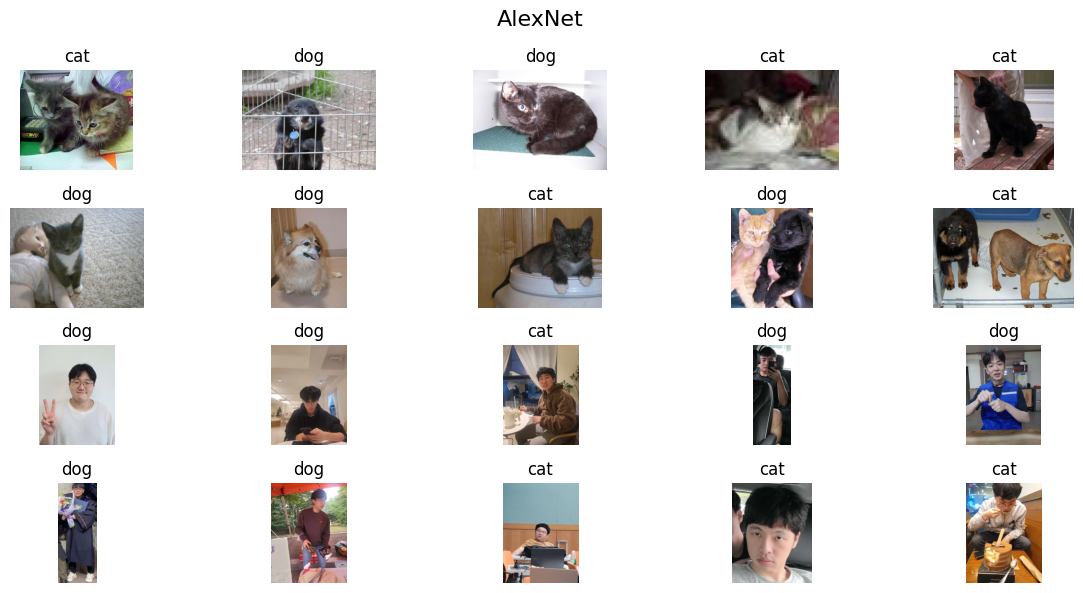

In [17]:
# 예측 결과에 대해 이미지와 함께 출력
display_image_grid(test_images_filepaths)